In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/prices.csv", parse_dates=["date"], index_col="date")
AAPL = df[df["symbol"].isin(["AAPL"])].drop(["symbol","volume"], axis=1)
AAPL= AAPL.div(AAPL.iloc[0])
AAPL.head()

,close
date,
2010-01-04,1.000000
2010-01-05,1.001729
2010-01-06,0.985795
2010-01-07,0.983973
2010-01-08,0.990514


# Creating time-shifted features

In machine learning for time series, it's common to use information about previous time points to predict a subsequent time point.

In this exercise, you'll "shift" your raw data and visualize the results. You'll use the percent change time series that you calculated in the previous chapter, this time with a very short window. A short window is important because, in a real-world scenario, you want to predict the day-to-day fluctuations of a time series, not its change over a longer window of time.

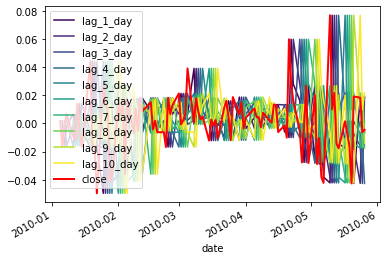

In [2]:
import numpy as np

prices_perc = AAPL['close'].pct_change()
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc.iloc[:100].plot(color='r', lw=2)
ax.legend(loc='best')
plt.show()

# Special case: Auto-regressive models

Now that you've created time-shifted versions of a single time series, you can fit an auto-regressive model. This is a regression model where the input features are time-shifted versions of the output time series data. You are using previous values of a timeseries to predict current values of the same timeseries (thus, it is auto-regressive).

By investigating the coefficients of this model, you can explore any repetitive patterns that exist in a timeseries, and get an idea for how far in the past a data point is predictive of the future.

In [3]:
from sklearn.linear_model import Ridge
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

# Visualize regression coefficients

Now that you've fit the model, let's visualize its coefficients. This is an important part of machine learning because it gives you an idea for how the different features of a model affect the outcome.

The shifted time series DataFrame (prices_perc_shifted) and the regression model (model) are available in your workspace.

In this exercise, you will create a function that, given a set of coefficients and feature names, visualizes the coefficient values.

In [4]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

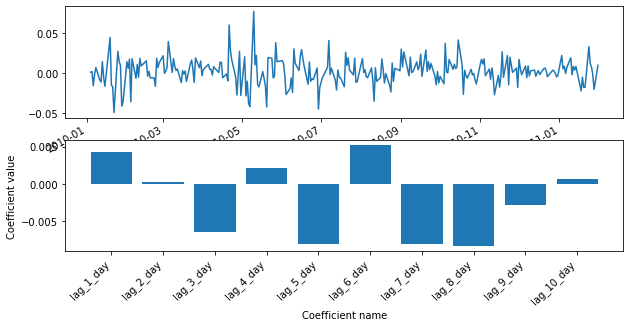

In [5]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients( model.coef_,X.columns, ax=axs[1])
plt.show()

# Auto-regression with a smoother time series

Now, let's re-run the same procedure using a smoother signal. You'll use the same percent change algorithm as before, but this time use a much larger window (40 instead of 20). As the window grows, the difference between neighboring timepoints gets smaller, resulting in a smoother signal. What do you think this will do to the auto-regressive model?

In [6]:
# Calculate rolling percentage change
prices_perc = AAPL['close'].pct_change().rolling(window=30).mean()

# Drop rows with NaN values resulting from the rolling operation
prices_perc.dropna(inplace=True)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc.fillna(np.nanmedian(prices_perc))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

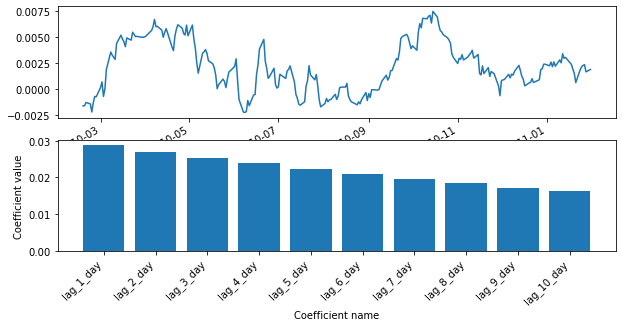

In [7]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients( model.coef_,X.columns, ax=axs[1])
plt.show()

# Cross-validation with shuffling

As you'll recall, cross-validation is the process of splitting your data into training and test sets multiple times. Each time you do this, you choose a different training and test set. In this exercise, you'll perform a traditional `ShuffleSplit` cross-validation on the company value data from earlier. Later we'll cover what changes need to be made for time series data. The data we'll use is the same historical price data for several large companies.

In [8]:
def visualize_predictions(results):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Loop through our model results to visualize them
    for ii, (prediction, score, indices) in enumerate(results):
        # Plot the predictions of the model in the order they were generated
        offset = len(prediction) * ii
        axs[0].scatter(np.arange(len(prediction)) + offset, prediction, label='Iteration {}'.format(ii))
        
        # Plot the predictions of the model according to how time was ordered
        axs[1].scatter(indices, prediction)
    axs[0].legend(loc="best")
    axs[0].set(xlabel="Test prediction number", title="Predictions ordered by test prediction number")
    axs[1].set(xlabel="Time", title="Predictions ordered by time")
    plt.show()

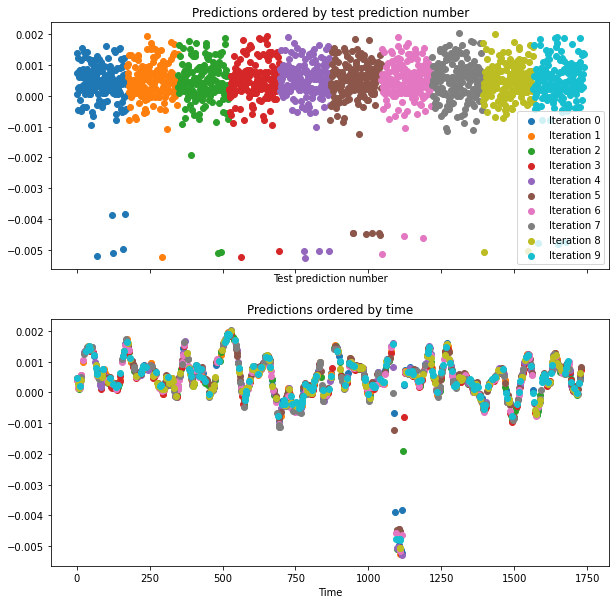

In [9]:
# Import ShuffleSplit and create the cross-validation object
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
import numpy as np

# Assuming X and y are your feature matrix and target variable respectively

cv = ShuffleSplit(n_splits=10, random_state=1)
model = Ridge()

# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X.iloc[tr], y.iloc[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X.iloc[tt])
    score = r2_score(y.iloc[tt], prediction)  # Reverse the order of y and prediction
    results.append((prediction, score, tt))

# Custom function to quickly visualize predictions
visualize_predictions(results)


# Cross-validation without shuffling

Now, re-run your model fit using block cross-validation (without shuffling all datapoints). In this case, neighboring time-points will be kept close to one another. How do you think the model predictions will look in each cross-validation loop?

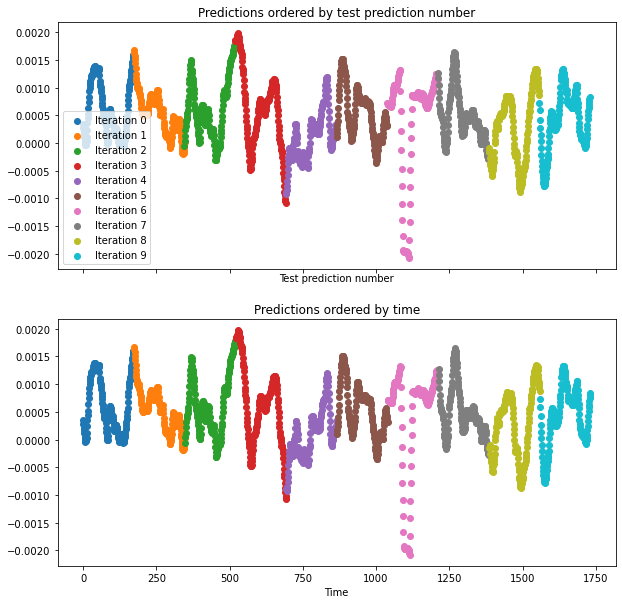

In [10]:
# Create KFold cross-validation object
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, shuffle=False)


# Iterate through CV splits
results = []
for tr, tt in cv.split(X, y):
    # Fit the model on training data
    model.fit(X.iloc[tr], y.iloc[tr])
    
    # Generate predictions on the test data, score the predictions, and collect
    prediction = model.predict(X.iloc[tt])
    score = r2_score(y.iloc[tt], prediction)  # Reverse the order of y and prediction
    results.append((prediction,score,  tt)) # 

# Custom function to quickly visualize predictions
visualize_predictions(results)

# Time-based cross-validation

Finally, let's visualize the behavior of the time series cross-validation iterator in scikit-learn. Use this object to iterate through your data one last time, visualizing the training data used to fit the model on each iteration.

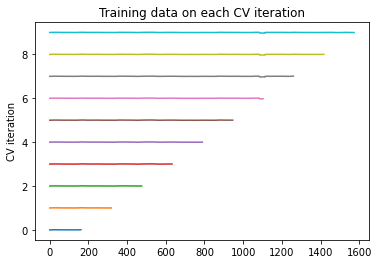

In [11]:
# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=10)

# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii + y[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()

# Stationarity

First, let's confirm what we know about stationarity. Take a look at these time series.
Which of the following time series do you think are not stationary?

<center><img src="images/04.01.png"  style="width: 400px, height: 300px;"/></center>

- B and C (variability or mean changes over time)

# Bootstrapping a confidence interval

A useful tool for assessing the variability of some data is the bootstrap. In this exercise, you'll write your own bootstrapping function that can be used to return a bootstrapped confidence interval.

In [12]:
from sklearn.utils import resample

def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 2-D dataset."""
    # Create empty array to fill the results
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

# Calculating variability in model coefficients

In this lesson, you'll re-run the cross-validation routine used before, but this time paying attention to the model's stability over time. You'll investigate the coefficients of the model, as well as the uncertainty in its predictions.

Begin by assessing the stability (or uncertainty) of a model's coefficients across multiple CV splits. Remember, the coefficients are a reflection of the pattern that your model has found in the data.

In [13]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    # Fit the model on training data and collect the coefficients
    model.fit(X.iloc[tr], y.iloc[tr])
    coefficients[ii] = model.coef_

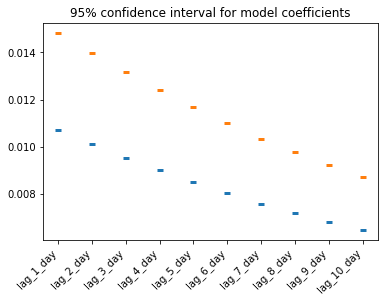

In [14]:
feature_names = X.columns
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

# Visualizing model score variability over time

Now that you've assessed the variability of each coefficient, let's do the same for the performance (scores) of the model. Recall that the TimeSeriesSplit object will use successively-later indices for each test set. This means that you can treat the scores of your validation as a time series. You can visualize this over time in order to see how the model's performance changes over time.

In [16]:
def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]

In [17]:
from sklearn.model_selection import cross_val_score
from functools import partial

# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
times_scores = X.index[-len(scores):]
# Convert to a Pandas Series object
scores_series = pd.Series(scores, name='score', index=times_scores) # 

# Bootstrap a rolling confidence interval for the mean score
# scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
# scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))
scores_lo = scores_series.rolling(20).apply(lambda x: np.percentile(x, 2.5))
scores_hi = scores_series.rolling(20).apply(lambda x: np.percentile(x, 97.5))

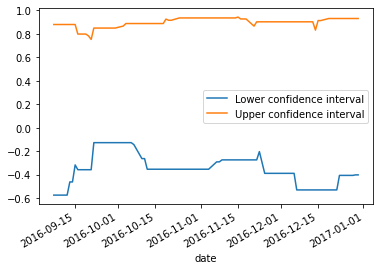

In [18]:
# Plot the results
fig, ax = plt.subplots()
scores_lo.plot(ax=ax, label="Lower confidence interval")
scores_hi.plot(ax=ax, label="Upper confidence interval")
ax.legend()
plt.show()

# Accounting for non-stationarity

In this exercise, you will again visualize the variations in model scores, but now for data that changes its statistics over time.

In [19]:
from sklearn.model_selection import cross_val_score
times_scores = X.index[-len(scores):]
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

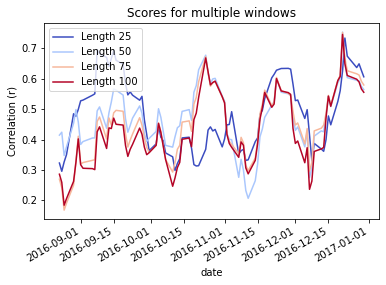

In [20]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
plt.show()